In [1]:
import pdb
import numpy as np
from copy import deepcopy
from energyNorms import *
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

### implementing matlab functions missing in python ###

def accumarray(idx_arr,val,size):
    ''' only for 2D index'''
    
    out = np.zeros(size)
    if hasattr(val,'shape'):
        for i in range(len(idx_arr)):
            out[idx_arr[i,0],idx_arr[i,1]]+= val[i]
        return out
    else:
        for i in idx_arr:
            out[i[0],i[1]]+=val
        return out

def isnumeric(obj):
    try:
        obj + 0
        return True
    except:
        return False
    
def histc(X, bins):
    map_to_bins = np.digitize(X,bins)
    r = np.zeros((len(X[0,:]),len(bins)))
    for j in range(len(map_to_bins[0,:])):
        for i in map_to_bins[:,j]:
            r[j,i-1] += 1
    return [r, map_to_bins]

In [2]:
class MapGeometry:
    def __init__(self,dim):
        self.dimension = dim
        self.preproc = False
        self.PCs = []
    
    def getDimension(self):
        dim = self.dimension
        return dim
    
    def getInternalCoordinates(self):
        coord = self.internal
        return coord
    
    def getMappedCoordinates(self):
        coord = self.mapped
        return coord
    
    def getLinks(self):
        # def to access edges of map. 
        # links is k-by-2 matrix. Each row contains two numbers of
        # nodes which form one edge.
        links = self.links
        return links
    
    def getRibs(self):
        # Function to access ribs of map
        # ribs is k-by-3 matrix. Each row contains three numbers of 
        # nodes which form this rib.
        ribs = self.ribs
        return ribs
    
    def getDisp(self):
        # def to access disp of map
        # disp is non-negative number which presents the maximal
        # distance from data point to nearest original node.
        disp = self.disp
        return disp
    
    def init(self,data,_type='pci',_reduce=0):
        
        data = self.preprocessDataInit(data, _reduce)

        if 'random'.casefold() == _type.casefold():
            #Random generation
            #Calculate intervals for each coordinates
            mini = np.min(data,axis=0)
            maxi = np.max(data,axis=0)-mini
            #Generate random coordinates
            data = np.random.uniform(size=(self.internal.shape[0],data.shape[1]))
            #Scale coordinates
            data = data*maxi
            #shift coordinates
            self.mapped = data+mini
        elif 'randomSelection'.casefold() == _type.casefold():
            #Random selection
            #Generate vector of prototype numbers
            data = np.random.uniform(high = data.shape[0],size=(self.internal.shape[0],1))
            #Get selected points and put them as mapped coordinates
            self.mapped = data[data,:]
            
        elif 'pci'.casefold() == _type.casefold():
            # Principal component initialization
            # Get mean and PCs
            if self.preproc:
                # Data were preprocessed
                V = np.eye(data.shape[1], self.dimension)
                tmp = data[:,:self.dimension]
                meanDat = np.zeros((1, data.shape[1]))
            else:
                # Get required number of PCs:
                meanDat = self.means 
                V = self.PCs[:, :self.dimension+1]
                tmp = data @ V
            #Calculate mean and dispersion along each PCs
            mini = np.min(tmp,axis=0)
            maxi = np.max(tmp,axis=0)
            meant = np.mean(tmp,axis=0)
            disper = np.min(np.array([[meant - mini],[maxi - meant]]),axis=0)
            #Calculate mean and dispersion along internal coordinates
            minI = np.min(self.internal,axis=0)
            maxI = np.max(self.internal,axis=0)
            meanI = np.sum(self.internal,axis=0) / self.internal.shape[0]
            disP = np.min(np.array([[meanI - minI],[maxI - meanI]]),axis=0)
            #auxiliary calculations
            V = V * (disper / disP)
            #final values
            self.mapped=((self.internal- meanI) @ V.T) + meanDat
        else:
            raise ValueError('type "' +_type+ '" is not recognized as valid type of initialization')
        data, _  = self.associate(self.mapped, data)
        self.disp = np.sqrt(np.max(data,axis=0))
    
    def preprocessDataInit(self, data, reduce):

        #Perform data preprocessing if necessary (see description of
        #'reduce')
        #
        #Inputs:
        #   map is MapGeometry object to initialise map.
        #   data is n-by-m matrix with n data points and m coordinates for
        #       each point (each row is one data point)
        #   reduce is integer. If 'reduce' is positive and is
        #       less than n then specified number of the first principal
        #       components are used. If 'reduce' is zero and m>n then the
        #       first n-1 principal components is used. If 'reduce' is
        #       positive and is greater or equal to n or 'reduce' is zero
        #       and n>m then dimensionality reduction is not performed. If
        #       reduce is negative then -reduce PCs are calculated but
        #       dimensionality reduction is not performed.

        # Get sizes
        [n, m] = data.shape
        reduce = np.floor(reduce)
        if reduce >= m or (reduce == 0 and n > m):
            # Calculate 3 PCs and mean but do not apply preprocessing
            k = 3
            if k > m:
                k = m
            
            self.preproc = False
        elif reduce < 0:
            k = -reduce
            if k > m:
                k = m
            
            self.preproc = False
        else:
            # Define required number of PCs
            k = n - 1
            if reduce > 0 and reduce > k:
                k = reduce
            
            self.preproc = True
        # Search required number of PCs
        self.means = np.mean(data,axis=0)
        [_, D, VH] = np.linalg.svd(data-self.means,full_matrices=False)
        V = VH.T   # for consistency with matlab version
        D = D[:k]
        ind = D[::-1].argsort()
        V = V[:,ind]
        # Standardise direction of PCs
        ind = np.diag(V) < 0
        V[:, ind] = -V[:, ind]
        # Store results
        self.PCs = V
        
        # Preprocess data if it is required
        if self.preproc:
            data = self.preprocessData(data)
            
        return data
    
    def preprocessData(self, data):
        if not self.preproc:
            return
        data = (data - self.means) @ self.PCs
        return data

    def deprocessData(self, data):
        if not self.preproc:
            return

        data = (data  @ self.PCs.T) + self.means
        return data
    
    def project(self, points, _type, kind):
        #Project is the def to calculate projection of data point
        #(points) into map. There are d+1 types of projection for d
        #dimensional map: 0 means projection into nearest node of map, 1
        #means projection onto nearest edge of map, 2 means projection onto
        #nearest face of map. Projection can be calculated in the internal
        #or mapped coordinates. There are three input arguments for this
        #method: set of point to project, type of projection (integer
        #number) and coordinates space for projection: internal or
        #mapped.
        #
        #Inputs:
        #   map is MapGeometry object to use
        #   points is n-by-m matrix where m is number of mapped coordinates
        #       and n is number of points to project.
        #   type is type of projection: 0 or 1 for 1D maps, 0,1 or 2 for 2D
        #       maps.
        #   kind is one of words 'internal' for internal coordinates and
        #       'mapped'for mapped coordinates.
        coord, _ = projectPrime(self, self.mapped, points, _type, kind)
        return coord
        
    def projectPrime(self, nodes, points, _type, kind):
        #projectPrime is the def to calculate projection of data point
        #(points) into map. There are d+1 types of projection for d
        #dimensional map: 0 means projection into nearest node of map, 1
        #means projection onto nearest edge of map, 2 means projection onto
        #nearest face of map. Projection can be calculated in the internal
        #or mapped coordinates. There are three input arguments for this
        #method: set of point to project, type of projection (integer
        #number) and coordinates space for projection: internal or
        #mapped.
        #
        #Inputs:
        #   map is MapGeometry object to use
        #   nodes is the current state of the mapped nodes. It can be
        #       diffed from map.mapped. It is useful for estimation of
        #       calculated mapped nodes without fixing it into map object
        #   points is n-by-m matrix where m is number of mapped coordinates
        #       and n is number of points to project.
        #   type is type of projection: 0 or 1 for 1D maps, 0,1 or 2 for 2D
        #       maps.
        #   kind is one of words 'internal' for internal coordinates and
        #       'mapped'for mapped coordinates.
        #
        #Outputs:
        #   coord is the set of requested projections.
        #   dist is the vector of distances from points to map.
        # Check which type of coordinates is necessary to return
        cType = 'mapped'.casefold() == kind.casefold()
        N = points.shape[0]

        if _type == 0:
            #Projection to the nearest node
            #Search the nearest node
            [dist, num] = self.associate(nodes, points)
            if cType:
                coord = nodes[num,:]
            else:
                coord = self.internal[num,:]
        elif _type == 1:
            #projection onto nearest edge
            #Get array of edges end
            V2 = nodes[self.links[:,2],:].T
            #Form matrix of edges directions
            _dir = nodes[self.links[:,1],:].T -V2
            #Calculate squared length of edge directions
            _len = np.sum(_dir**2,axis=0)
            #Calculate projections length (l in documentation, matrix
            #analogue of (2))
            pr = (points*_dir)-np.sum(V2*_dir,axis=0)
            #Copy projections to normalize (l* in documentation)
            prn = pr/_len
            #Non negativity
            prn[prn<0] = 0
            #Cut too long projections (it is the same as step 3 of
            #algorithm in documentation)
            prn[prn>1] = 1
            #Calculate distances:
            dist = (np.sum(points**2,axis=1))+(np.sum(V2**2,axis=0)
                -2*points*V2+prn*(prn*_len-2*pr))
            #Select the nearest edge
            [dist, edge] = np.min(dist,axis=1)
            #form index to find length of projections
            ind = np.ravel_multi_index(np.concatenate((list(range(N+1)),edge)),([N,self.links.shape[0]]))
            if cType:
                coord = ((1-prn(ind))*nodes[self.links[edge,1],:])+(prn(ind)*nodes[self.links[edge,0],:])
            else:
                coord = (1-prn[ind])*self.internal[self.links[edge,1],:]+prn[ind]*self.internal[self.links[edge,0],:]
        elif _type == 2:
            #Projections onto face
            if not any(methods(self).casefold() ==  'getFaces'.casefold()):
                raise ValueError('request of the projection onto face for MapGeometry without methods "getFaces"')
            #Get faces
            face = self.getFaces
            #form auxiliary vectors
            Y2 = (nodes[face[:,2],:]).T
            Y20 = Y2-(nodes[face[:,0],:]).T
            Y21 = Y2-(nodes[face[:,1],:]).T
            Y10 = (nodes[face[:,1],:]-nodes[face[:,0],:]).T
            Y20Y20 = np.sum(Y20**2,axis=0)
            Y21Y20 = np.sum(Y20*Y21,axis=0)
            Y21Y21 = np.sum(Y21**2,axis=0)
            #Calculate projections
            A20 = np.sum(Y2*Y20,axis=0)-points*Y20
            A21 = np.sum(Y2*Y21)-points*Y21
            A10 = (A20-A21-np.sum(Y21*Y10,axis=0))/np.sum(Y10**2,axis=0)
            tmp = Y20Y20*Y21Y21-Y21Y20**2
            A0 = (A20*Y21Y21-A21*Y21Y20)/tmp
            A1 = (A21*Y20Y20-A20*Y21Y20)/tmp
            A20 = A20/Y20Y20
            A21 = A21/Y21Y21
            #Normalize projections
            A20N = A20
            A20N[A20N<0] = 0
            A20N[A20N>1] = 1
            A21N = A21
            A21N[A21N<0] = 0
            A21N[A21N>1] = 1
            A10[A10<0] = 0
            A10[A10>1] = 1
            tmp = A0<0
            A0[tmp] = 0
            A1[tmp] = A21N[tmp]
            tmp = A1<0
            A0[tmp] = A20N[tmp]
            A1[tmp] = 0
            tmp = (1-(A0+A1))<0
            A0[tmp] = A10[tmp]
            A1[tmp] = 1-A10[tmp]
            #Calculate distances
            dist = (np.sum(points**2,axis=1)+np.sum(Y2**2,axis=0)-2*points*Y2
                +(A0*Y20Y20)*(A0-2*A20)
                +(A1*Y21Y21)*(A1-2*A21)
                +2*(A0*A1)*Y21Y20)
            #Select the nearest face
            [dist, tmp] = np.min(dist,axis=1)
            #form index to find length of projections
            ind = np.ravel_multi_index(np.concatenate((list(range(N+1)),tmp)),[N,face.shape[0]])

            if cType:
                coord = (A0[ind]*nodes[face[tmp,0],:]
                    +A1[ind]*nodes[face[tmp,1],:]
                    +(1-A0[ind]-A1[ind])*nodes[face[tmp,2],:])
            else:
                coord = (A0[ind]*self.internal[face[tmp,0],:]
                    +A1[ind]*self.internal[face[tmp,1],:]
                    +(1-A0[ind]-A1[ind])*self.internal[face[tmp,2],:])
        else:
            raise ValueError('unacceptable type or projections')
        return coord, dist

    def associate(self,node, data):
        #associate identify the nearest node for each data point and
        #return the squared distance between selected node and data
        #point and number of nearest node.
        #
        #Inputs:
        #   node is n-by-k matrix of mapped coordinates for tested state
        #       of map, where n is number of nodes and m is dimension of
        #       data space.
        #   data is m-by-k data points to test, where m is number of
        #       points and k is dimension of data space.
        #
        #Outputs:
        #   dist is m-by-1 matrix of squared distances from data point to
        #       nearest node
        #   klass is m-by-1 vector which contains number of nearest node
        #       for each data point.

        dist = (np.sum(data ** 2, axis=1,keepdims=1)+np.sum(node**2, axis=1,keepdims=1).T) - 2 * (data @ node.T)
        [dist, klas] = np.min(dist, axis=1), np.argmin(dist, axis=1) 
        return dist, klas

    def extend(self, data, val=1):
        #extend create extended version of map to reduce/prevent border
        #effect.
        #
        #Inputs:
        #   map is MapGeometry object to extend
        #   val is optional parameter to customise process:
        #       is greater of equal 1 is used to add val ribbons to each
        #           side of map.
        #       is positive number between 0 and 1 means maximal acceptable
        #           fraction of points which are projected onto map border.
        #       default value is 1
        #   data is n-by-m data points to test, where n is number of
        #       points and m is dimension of data space.

        # Check the val value
        if val < 0:
            raise ValueError(['Value of val attribute must be positive value'+
                ' between 0 and 1 for fraction restriction or'+
                ' positive integer to add val ribbons to each'+
                ' side of map']) 
        if val < 1:
            # Restriction for fraction of border cases
            dat = self.preprocessData(data) 
            newMap = deepcopy(self) 
            while newMap.borderCases(dat, newMap.getBorder()) > val:
                newMap = newMap.extendPrim() 
        else:
            val = np.floor(val) 
            newMap = self.extendPrim() 
            for k in range(2,val+1):
                newMap = newMap.extendPrim() 

        return newMap

    def FVU(self, data, node=None, _type=1):
        #Calculate fraction of variance unexplained for specified data and
        #nodes.
        #
        #Inputs:
        #   map is MapGeometry object to use
        #   data is set of data points
        #   node is the set of considered mapped nodes. If t is omitted or
        #       empty then the map.mapped is used.
        #   type is the type of projection: 0 means projection into nearest
        #       node of map, 1 means projection onto nearest edge of map, 2
        #       means projection onto nearest face of map. If this argument
        #       is omitted then 1 is used.
        if node==None:
            node = self.mapped
        #Calculate base variance
        N = data.shape[0] 
        meanS = np.sum(data,axis=0)/N 
        base = np.sum(np.reshape(data,(-1),order='F')**2)-N*np.sum(meanS**2) 

        #Get distances to map
        [_, dist] = self.projectPrime(node, data, _type, 'mapped') 

        #Calculate FVU
        fvu = np.sum(dist,axis=0)/base 

        return fvu

    def putMapped(self, newMapped):
        #This def is used for the putting the fitted mapped
        #coordinates of map.
        #
        #Inputs:
        #   newMapped is new matrix of mapped coordinates. It must have
        #       the same size as previously defined matrix
        if not self.mapped.shape==newMapped.shape:
            raise ValueError('Matrix newMapped must have the same size as matrix mapped') 
        self.mapped = newMapped 


    def borderCases(self, data, _list):
        #borderCases calculates fraction of border cases among all data
        #points.
        #
        #Inputs:
        #   map is MapGeometry object to use
        #   data is n-by-m data points to test, where n is number of
        #       points and m is dimension of data space.
        #   list is list of indices of border nodes.

        [_, ass] = self.associate(self.getMappedCoordinates, data) 
        # Calculate number of points for each node
        N = self.getMappedCoordinates.shape[0]
        tmp = accumarray(ass + 1, 1, [N + 1, 1]) 
        # Normalise and remove dummy element
        tmp = tmp[1:] 
        frac = np.sum(tmp[_list],axis=0) / data.shape[0] 
        return frac

In [3]:
class OneDMap(MapGeometry):
    #OneDMap is descendant for piecewise linear map
    #Constructor contains one argument which is number of nodes
    def __init__(self,N):
        # Create map
        self.map = MapGeometry(1)
        # Store size
        self.map.sizes = N
        # Calculate internal coordinates of nodes
        self.map.internal = np.array(range(N))[:,None]
        # Form array of links
        self.map.links = [self.map.internal[:-1], self.map.internal[1:]]
        # Form array of ribs
        self.map.ribs = [self.map.internal[1:-2], self.map.internal[1:-1], self.map.internal[2:]]
        # Set self.mapped coordinates to empty set
        self.map.mapped = []

    def extendPrim(self):
        # Get size of existing self.map
        n = self.map.sizes
        # Create new self.map with greater size
        newMap = OneDmap(n + 2)
        # Copy known positions of nodes into new self.map
        newMap.mapped[1:n + 2, :] = newMap.mapped
        # Calculate positions of the first and last nodes
        newMap.mapped[0, :] = 2 * newMap.mapped[1, :]- newself.map.mapped[2, :]
        newMap.mapped[n + 1, :] = 2 * newMap.mapped[n, :]- newMap.mapped[n-1, :]
        return newMap

    def getBorder(self):
        res = [1, self.map.sizes]
        return res
    
    
    
class rect2DMap(MapGeometry):
    #OneDMap is descendant for piecewise linear map
    #   Constructor contains two argument which are number of rows and
    #   number of columns
    def __init__(self,rows,cols):
        # Create map
        super().__init__(2)
        # Store size
        self.sizes = [rows, cols] 
        # Calculate internal coordinates of nodes
        N=rows*cols 
        a1=np.tile(np.array(range(cols)),(rows,1)) 
        a2=np.tile(np.array(range(rows))[:,None],(1,cols)) 
        self.internal = np.array([a2.reshape(-1),a1.reshape(-1)]).T        
        # Form array of links
        A=np.reshape(np.array(range(N)),(rows,cols),order='F') 
        B=A[:-1,:] 
        C=A[1:,:] 
        D=A[:,:-1] 
        E=A[:,1:]
        self.links = np.concatenate([
            np.concatenate([B.reshape((-1,1),order='F'), C.reshape((-1,1),order='F')],axis=1),
            np.concatenate([D.reshape((-1,1),order='F'), E.reshape((-1,1),order='F')],axis=1)
        ])
        # Form array of ribs
        B1=A[0:-2,:] 
        B2=A[1:-1,:] 
        B3=A[2:,:]
        C1=A[:,:-2]
        C2=A[:,1:-1] 
        C3=A[:,2:] 
        self.ribs = np.concatenate([
            np.concatenate([B1.reshape((-1,1),order='F'), B2.reshape((-1,1),order='F'), B3.reshape((-1,1),order='F')],axis=1),
            np.concatenate([C1.reshape((-1,1),order='F'), C2.reshape((-1,1),order='F'), C3.reshape((-1,1),order='F')],axis=1)
        ]) 
        # Form array of faces
        B1 = A[:-1,:-1]
        B2 = A[1:,:-1]
        B3 = A[:-1,1:]
        C1 = A[:-1,1:]
        C2 = A[1:,:-1]
        C3 = A[1:,1:]
        self.faces = np.concatenate([
            np.concatenate([B1.reshape((-1,1),order='F'), B2.reshape((-1,1),order='F'), B3.reshape((-1,1),order='F')],axis=1),
            np.concatenate([C1.reshape((-1,1),order='F'), C2.reshape((-1,1),order='F'), C3.reshape((-1,1),order='F')],axis=1)
        ]) 
        # Set mapped coordinates to empty set
        self.mapped = [] 

    def getFaces(self):
        #def to access to the faces of map.
        #face is k-by-3 matrix. Each row contains three numbers of
        #nodes which form one face.
        face=self.faces
        return face

    def extendPrim(self):
        # Get size of existing map
        n = self.sizes(1) 
        m = self.sizes(2) 
        N = n + 2 
        M = m + 2 
        NM = N * M 
        # Create new map with greater size
        newMap = rect2DMap(N, M) 
        # Form list of old nodes
        ind = np.array(range(1,NM)) 
        ind[newMap.getBorder] = []
        # Copy known positions of nodes into new map
        newMap.mapped[ind, :] = self.mapped 
        # Calculate positions of the nodes added to left side
        ind = np.array(range(1,n)) + 1 
        newMap.mapped[ind, :] = (2 * newMap.mapped[ind + N, :]
            - newMap.mapped[ind + 2 * N, :] )
        # Calculate positions of the nodes added to right side
        ind = NM - N + np.array(range(2,NM+1)) - 1 
        newMap.mapped[ind, :] = (2 * newMap.mapped[ind - N, :]
            - newMap.mapped[ind - 2 * N, :] )
        # Calculate positions of the nodes added to bottom side
        ind = np.array(range(0,NM,N)) 
        newMap.mapped[ind, :] = (2 * newMap.mapped[ind + 1, :]
            - newMap.mapped[ind + 2, :] )
        # Calculate positions of the nodes added to top side
        ind = np.array(range(N-1,NM,N)) 
        newMap.mapped[ind, :] = (2 * newMap.mapped[ind - 1, :]
            - newMap.mapped[ind - 2, :] )
        
        return newMap

    def getBorder(self):
        # Get map sizes
        n = self.sizes(1) 
        m = self.sizes(2) 
        # Form list of border nodes
        res = [np.array(range(2,n)) - 1,                  # left edge
            (m - 1) * n + np.array(range(2,n)) * m - 1,   # right edge
            (np.array(range(m)) - 1) * n + 1,             # bottom edge
            np.array(range(1,m)) * n]                     # top edge
        return res 

def LSqrt(x):
    #Lsqrt is the sqrt energy potential
    return np.sqrt(x)

def L1(x):
    #L1 is the L1 norm energy potential
    return np.abs(x)

def L1_5(x):
    return np.abs(x)**(3/2)

def L2(x):
    #L2 is the L2 norm energy potential
    return x**2

def LLog(x):
    #L1 is the logarithmic energy potential
    return np.log1p(x)

In [4]:
def constStretch(*args):
    stretch = constStretching 
    return stretch

def constBend(*args):
    bend = constBending 
    return bend

def EM(
    _map, 
    data, 
    strFun = constStretch,
    constStretching = 0.7,
    bendFun = constBend,
    constBending = 0.7,
    weights = [],
    func = [],
    intervals = [],
    nInt = 5,
    delta = 1,
    _type = 'none',
    **kwargs
      ):
    
    #EM is def to fit map to data
    #   Syntax
    #   EM( map, data )
    #   EM( __, Name, Value )
    #   
    #Inputs:
    #   map is an object of MapGeometry class or subclass of this class.
    #   data is n-by-m matrix which is the data set to fit. Each row contains
    #       m coordinates of one data point.
    #   Name can be one of the following:
    #       'type' is one of the following strings:
    #          'hard' is hard map with stretch = 1 and bend = 1
    #           'medium' is more flexible map with stretch = 0.7 and bend = 0.7
    #           'soft' is soft map with stretch = 0.5 and bend = 0.5
    #           If 'type', 'stretch' and 'bending' are omitted then 'medium' is
    #           used. 
    #       'stretch' is a positive numeric value which is the value of
    #           stretching modulo or a def with syntax
    #               val = stretch( epoch )
    #           where epoch is number of epoch (see epoch definition below) and
    #           val is the nonnegative stretching modulo to use on specified
    #           epoch. Epochs are numerated from 1.
    #           Default value corresponds to type 'medium'
    #       'bend' is a positive numeric value which is the value of the
    #           bending modulo or a def with syntax 
    #               val = bend( epoch )
    #           where epoch is number of epoch (see epoch definition below) and
    #           val is the bending modulo to use on specified epoch. Epochs are
    #           numerated from 1. 
    #           Default value corresponds to type 'medium'
    #       'weights' is n-by-1 vector of weights for data points. Weights must
    #           be nonnegative.
    #       'intervals', intervals serves to specify user defined intervals.
    #           intervals is row vector. The first element must be zero. By
    #           default is created by usage of 'number_of_intervals' and
    #           'intshrinkage'. Maximal value M is calculated as maximum among
    #           data points of distance from data points to the nearest node of
    #           map after initiation. Then this value is multiplied by
    #           'intshrinkage'. All other borders are calculated as r(i) =
    #           M*i^2/p^2, where p is number_of_intervals'. Ignored if
    #           'potential' is not specified.
    #       'Number_of_intervals' specifies the number of intervals to
    #           automatic interval calculation. Default value is 5. Ignored if
    #           'potential' is not specified. 
    #       'intshrinkage' is fraction of maximal distance from data points to
    #           original map which is used for intervals shrinkage (see
    #           argument delta in defineIntervals). Default value is 1 (no
    #           shrinkage). Ignored if 'potential' is not specified.
    #       'potential' is majorant def for PQSQ. L2 distance without
    #           shrinkage is used if 'potential' is not specified.
    #
    # One epoch is fitting of map with fixed values of stretching and bending
    # modulo. This process can include several iterations of two step
    # algorithm:
    #   1. associate each data point with nearest node.
    #   2. recalculate node position.
    # Process of map fitting is stopped if new values of stretching and bending
    # modulo are the same as on previous epoch OR if both stretching and
    # bending modulo are zero.

    # Check the number of input attributes and types of the two first
    # attributes.
    if not issubclass(type(_map),MapGeometry):
        raise ValueError('Incorrect type of the "map" argument, it must be MapGeometry') 
    if not len(data.shape) == 2:
        raise ValueError('Incorrect type of the "data" argument, data must be a matrix') 
    
    # Data preprocessing
    data = _map.preprocessData(data)
    
    # Get sizes of data
    [n, dim] = data.shape

    # Default values of customisable variables
    
    # Decode varargin            
    if _type.casefold() == 'hard'.casefold():
        strFun = constStretch 
        constStretching = 1 
        bendFun = constBend 
        constBending = 1 
    elif _type.casefold() == 'medium'.casefold():
        strFun = constStretch 
        constStretching = 0.7 
        bendFun = constBend 
        constBending = 0.7 
    elif _type.casefold() == 'soft'.casefold():
        strFun = constStretch 
        constStretching = 0.5 
        bendFun = constBend 
        constBending = 0.5 
    
    # Check _type and length of weights
    if weights == []:
        weights = np.ones((n, 1)) 

    # Define total weights
    TotalWeight = np.sum(weights,axis=0) 
    weigh = weights 
    pFunc = [] 

    # Analyse PQSQ request
    if not(func==[]):
        if intervals==[]:
            #def has to create intervals by automatic way
            #nInt must be positive integer scalar
            if not(isinstance(nInt,int)) or not(np.isfinite(nInt)) or nInt < 1:
                raise ValueError(['Incorrect value of "number_of_intervals" argument'+
                    'It must be positive integer scalar']) 
            else:
                nInt = np.floor(nInt) 
                
            #delta has to be positive real scalar
            if isinstance(delta,complex) or not(np.isfinite(delta)) or delta < 0:
                raise ValueError(['Incorrect value of "intshrinkage" argument' +
                    'It must be positive real scalar']) 
            pFunc = definePotentialdef(_map.getDisp(), nInt, func, delta) 
        else:
            #intervals must contains non negative values in ascending order.
            #The first value must be zero.
            if intervals[0]!=0 or not(all(np.isfinite(intervals))) or any((intervals[1:-1]-intervals[0:-2])<=0):
                raise ValueError(['Incorrect values in argument intervals: intervals must'+
                    ' contains finite non negative values in ascending order.'+
                    ' The first value must be zero.']) 
                
            pFunc.intervals = [intervals.T, np.inf] 
            [pFunc.A, pFunc.B] = computeABcoefficients(intervals, func) 
    
    #Get initial state of nodes
    nodes = _map.getMappedCoordinates() 
    if nodes.shape[1] != dim:
        raise ValueError('Dimensions of mapped nodes and data must be the same') 
                                      
    N = nodes.shape[0] 
    #Form matrices B and C
    tmp = _map.getLinks() 
    B = np.diag(np.bincount(tmp.reshape(-1,order='F')))        
    tmp = accumarray(tmp, 1, size=[N, N]) 
    B = B - tmp - tmp.T 
    
    tmp = _map.getRibs() 
    C = np.diag(np.bincount(np.concatenate([tmp[:, [0]],  tmp[:, [2]]]).squeeze(),minlength=N)
        +np.bincount(tmp[:, 1],minlength=N)*4) 
    w = accumarray(tmp[:, [0,2]], 1,[N, N]) 
    tmp = accumarray(np.concatenate([tmp[:,[0,1]],tmp[:,[1,2]]]), 2, [N, N]) 
    C = C + w + w.T - tmp - tmp.T 

    # Start iterative process
    epoch = 1  # Number of iteration
    ass = np.zeros((n, 1))  # Initial associations. It is impossible combination
    qInd = np.zeros((n, 1)) 
    # Get initial modulo
    #stretch = strFun(epoch)
    #bend = bendFun(epoch) 
    stretch = constStretching
    bend = constBending
    while True:
        # Save old associations and q indices.
        oldAss = ass 
        oldQInd = qInd 
        # Find new associations
        [dist, ass] = _map.associate(nodes, data) 
        # Find indices for PQSQ if required
        if not(pFunc==[]):
            qInd = np.digitize(dist,pFunc.sqint)-1
            weigh =  weights * pFunc.A[qInd][:,None]

        # If nothing has changed then we have end of epoch
        if np.all(oldAss == ass) and np.all(oldQInd == qInd):
            epoch = epoch + 1 
            #tmp = strFun(epoch) 
            #tmp1 = bendFun(epoch) 
            tmp = stretch
            tmp1 = bend
            if tmp == 0 and tmp1 == 0:
                break 
            if abs(tmp - stretch) + abs(tmp1 - bend) == 0:
                break 
            stretch = tmp 
            bend = tmp1 
        
        # Form matrix A
        # For further robustness and so on we consider possibility of zeros in
        # ass and create dummy element
        ass = ass + 1 
        # Calculate number of points for each node
        tmp = np.bincount(ass.squeeze(), weigh.squeeze(), minlength=N + 1)
        # Normalise and remove dummy element
        NodeClusterRelativeSize = tmp[1:] / TotalWeight 
        # Create centroids
        NodeClusterCenters = np.zeros((N + 1, dim)) 
        for k in range(dim):
            NodeClusterCenters[:, k] = np.bincount(ass.squeeze(), (data[:, [k]] * weigh).squeeze(), minlength=N + 1) / TotalWeight 

        # Remove dummy element
        NodeClusterCenters = NodeClusterCenters[1:,:]
        
        # form SLAE
        SLAUMatrix = np.diag(NodeClusterRelativeSize) + stretch * B + bend * C 
        nodes = np.linalg.lstsq(SLAUMatrix, NodeClusterCenters,rcond=None)[0] 
    
        # Restore ass
        ass = ass - 1 
    
    # Put new nodes into map
    _map.putMapped(nodes) 

def definePotentialdef( 
    x,
    number_of_intervals, 
    potential_def_handle, 
    delta=1
    ):
    #definePotentialdef defines "uniform in square" intervals for trimming
    #threshold x and specified number_of_intervals.
    #   x is upper boundary of the interval last but one.
    #   number_of_intervals is required number of intervals.
    #   potential_def_handle is def handler for coefficients
    #       calculation.
    #   delta is coefficient of shrinkage which is greater than 0 ang not
    #       greater than 1.
    #Output argument potentialdef is structure with three fields:
    #   intervals is matrix m-by-number_of_intervals. Each row contains
    #       number_of_intervals values of thresholds for intervals and one
    #       additional value Inf
    #   A and B are the m-by-number_of_intervals matrices with quadratic
    #       defs coefficients
    class empty_class:
        pass

    potentialdef = empty_class()
    p = int(number_of_intervals - 1) 
    
    #intervals is the product of row and maximal coefficient multiplied by delta:
    intervals = (x * delta) * (np.array(range(p+1)) / p) ** 2 
    
    potentialdef.intervals = np.concatenate([intervals, np.array([np.inf])],axis=None) 
    potentialdef.sqint = potentialdef.intervals ** 2 
    [potentialdef.A,potentialdef.B] = computeABcoefficients(intervals, potential_def_handle) 
    return potentialdef

def computeABcoefficients(intervals, potential_def_handle):
    #PQSQR_computeABcoefficients calculates the coefficients a and b for
    #quadratic fragments of potential def.
    #   intervals is the 1-by-K matrix of intervals' boundaries without final
    #       infinity boundary.
    #   potential_def_handle is a handle of majorant def.
    #Get dimensions of intervals
    p = len(intervals)

    #Preallocate memory
    A = np.zeros(p) 
    B = np.zeros(p) 

    #Calculate value of def all boundaries
    pxk = potential_def_handle(intervals) 
    sxk = intervals**2 

    A[:p-1] = (pxk[:p-1]-pxk[1:p])/(sxk[:p-1]-sxk[1:p]) 
    B[:p-1] = (pxk[1:p]*sxk[:p-1]-pxk[:p-1]*sxk[1:p]) / (sxk[:p-1]-sxk[1:p]) 
    B[p-1] = pxk[p-1] 
    return A,B

In [7]:
def drawMap(_map, 
            data,
            classes = [], 
            markColour = [], 
            markShape = [], 
            markSize = [], 
            nodeMarker = 'none', 
            nodeMarkerSize = 2, 
            nodeColour = 'r', 
            lineWidth = 1, 
            newFigure = True, 
            source = [], 
            colMap = 'Viridis', 
            ColouringInSpace = False, 
            nodeMarkerSpecified = False, 
            lineWidthSpecified = False, 
            smooth = 0.15, 
            projType = 0, 
            axeS = [],
           ):

    #drawMap create figure and draw data and maps. If data dimension (number of
    #columns) is less than 3 then original data coordinate system is used. If
    #data dimension is greater than 3 then projection into space of the first
    #three PCs is used for drawing.
    #
    #Usage
    #   drawMap(map, data) 
    #   drawMap(__, Name, Value) 
    #
    #Inputs:
    #   map is object of class MapGeometry (descendant of this class).
    #   data is n-by-dim matrix of data points. Each row is one point.
    #   There are several possible 'Name', value pairs:
    #       'axes' is array of three different nonzero integer. This argument
    #           can be used for space with more than three coordinates only.
    #           The first number is vector for x axis, the second number is
    #           vector for y axis and the third number is vector for z axis.
    #           Positive number means number of coordinate in original space.
    #           Negative number mean specified principal component.
    #       'classes' is n-by-1 vector of class labels for points. Each label
    #           is positive integer number which is the index of cell array
    #           with marker descriptions. Marker descriptions can be specified
    #           by user in the arguments markColour, markShape, markSize.
    #           Otherwise standard marker is used for all points.
    #       'markColour' is K-by-1 vector of standard Matlab colours ('r', 'g',
    #           'b', 'y', 'm', 'c', 'w', 'k'). Value K is number of defined
    #           markers. If markColour is omitted then 'b' (blue) is used for
    #           all markers. 
    #       'markShape' is K-by-1 vector of standard Matlab marker shapes ('o',
    #           '+', '*', '.', 'x', 's', 'd', '^', 'v', '<', '>', 'p', 'h').
    #           Value K is number of defined markers. If markShape is omitted
    #           then 's' (square) is used for all markers.
    #       'markSize' is K-by-1 vector of positive numbers. Value K is number
    #           of defined markers. If markSize is omitted then 6 is used for
    #           all markers.
    #       'nodeMarker' is one of the possible marker shape symbol ('o', '+',
    #           '*', '.', 'x', 's', 'd', '^', 'v', '<', '>', 'p', 'h') or
    #           'none'. Default value is 'none'.
    #       'nodeMarkerSize' is positive number which is size of node marker.
    #           Default value is 6 
    #       'nodeColour' is one of the possible Matlab colours ('r', 'g', 'b',
    #           'y', 'm', 'c', 'w', 'k'). Default value is 'r' 
    #       'lineWidth' is non-negative number for map line width. Zero means
    #           absence of map at all (width of line is zero and 'nodeMarker'
    #           is 'none'. Default value is 0.5.
    #       'newFigure' is logical argument. Value true (default) causes
    #           creation of new figure. Value false causes usage of current
    #           active figure. This option can be used, for example, for
    #           subplots.
    #       'coloring' defines the type of data to colour. It can have
    #               following values: 
    #           [] (empty) means no colouring. It is default value.
    #           'density' is density colouring. It is equivalent to vector of
    #               ones.
    #           fun is def handle of form def res = fun(X), where X
    #               is n-by-d matrix with one data point per row and res is
    #               n-by-1 vector with values to use. Coordinate of vector X
    #               are defined in PREPROCESSED space.
    #           k is positive integer number. In this case k is number of
    #               coordinate to use.
    #           k is negative integer number. In this case map is coloured by
    #               value of projection on the k'th principal component.
    #           vect is n-by-1 vector with data defined def. Each element
    #               of vector corresponds to data point in matrix data.
    #           matr is N-by-(d+1) matrix with one data point in the first d
    #               columns of each row and value of def of this point in
    #               the last column. For example to calculate density def
    #               it is necessary to send data matrix with 1 in (d+1) column. 
    #       'ColorMap' is colormap to use for current graph. This parameter has
    #           meaning for maps with colouring only. Colormap is standard
    #           Matlab colormap. It can be one of predefined colormaps or
    #           user defined. For more details find Colormap in the Matlab
    #           documentation. 
    #       'ColoringInSpace' is logical attribute. True value means
    #           calculation of density or another data defined colouring
    #           without projection onto map. False (default) value means
    #           firstly projection of data onto map and then calculation of
    #           colouring.
    #       'Smooth' is positive real number. It is parameter of smoothing of
    #           def interpolation for densities and other defs
    #           defined in the data points. Default value is 2. Data
    #           interpolation is implemented in radial basis def like
    #           fasion: for query point x we calculate squared distance to each
    #           data point d(i). Value of def in the point x is sum of
    #           exp(-d(i)/(smooth*s2)) where s2 is mean of variances of all
    #           attributes.
    #       'projType' is type of projection onto map. Projection is necessary
    #           to create colouring from the def defined in the data
    #           points including densities. projType can have following values: 
    #               0 is projection to the nearest node,
    #               1 is projection to the nearest edge,
    #               2 is projection to the nearest face.
    #           default value is 0.

    # Data preprocessing
    data = _map.preprocessData(data) 

    #Get data dimension
    [N, dim] = data.shape 
    
    # Sanity check of arguments.
    if not classes.size > 0:
        classes = np.ones((N, 1)) 
        _cls = 1 
        nCls = 1
    else:
        _cls = np.unique(classes) 
        nCls = len(_cls)
        
    
    if markColour == []:
        markColour = np.tile('b', (nCls, 1)) 

    if markShape == []:
        markShape = np.tile('s', (nCls, 1)) 
    
    if markSize == []:
        markSize = [nodeMarkerSize]*nCls
    
    if lineWidth == 0:
        mapDraw = 0 
    else:
        mapDraw = 1 
    
    if not(axeS == []):
        if len(axeS) != 3 or not(isnumeric(axeS)) or any(axeS == 0) or len(np.unique(axeS)) != 3:
            raise ValueError(['"axes" must be array of three different nonzero'+
                ' integers. This argument can be used for space'+
                ' with more than three coordinates only. The'+
                ' first number is vector for x axis, the second'+
                ' number is vector for y axis and the third'+
                ' number is vector for z axis. Positive number'+
                ' means number of coordinate in original space.'+
                ' Negative number mean specified principal'+
                ' component.']) 

                
    #Create figure
    if newFigure:
        layout=go.Layout(
            height=800,
            width=800, 
            title="Elastic Map & Data",
            scene={"aspectmode": "cube",
                   "xaxis": {"title": "PC1", "showbackground":True},
                   "yaxis": {"title": "PC2", "showbackground":True},
                   "zaxis": {"title": "PC3", "showbackground":True}
                  }
        )
        
        fig = go.Figure(layout=layout)
        
    #Get map coordinates
    maps = _map.getMappedCoordinates() 

    # Check colouring parameters
    if not source == []:
        # Is map appropriate for colouring
        if not hasattr(_map, 'getFaces'):
            raise ValueError('Map must implement method "getFaces" for colouring') 

        if _map.getDimension() != 2:
            raise ValueError('Map coloring can be used for 2D maps only') 

        
        if not(isnumeric(smooth)) or smooth <= 0:
            raise ValueError('Smooth must be a positive number') 
        
        # Get internal map nodes' coordinates
        intern = _map.getInternalCoordinates() 
        
        # Extract grid
        [gridReady, nodeMap, nodeInt] = formGrid(_map.getFaces(), maps, intern) 
        
        # Check the correctness of source parameter
        # Identify type of source
        tmp = False 
        if isnumeric(source): 
            if np.isscalar(source):
                # It is number of coordinate or PCs
                source = np.round(source) 
                
                if source > 0:
                   # It is coordinate
                   # Get data in original space
                    temp = _map.deprocessData(nodeMap) 
                    if source > temp.shape[1]:
                        raise ValueError(['Number of coordinate (value of "coloring")'+
                       ' #d to draw must be positive and cannot be'+
                       ' greater than data space dimension #d']+
                       source, temp.shape[1]) 
                    f = temp[:, source]
                    
                elif source == 0:
                    raise ValueError(['Number of coordinate (value of "coloring")'+
                        ' to draw must be positive and number of'+
                        ' principal component must be negative.'+
                        ' Value of "coloring" cannot be zero']) 
                else:
                    if -source > _map.PCs.shape[1]:
                        raise ValueError(['Number of principal component (MINUS'+
                           ' value of "source") #d to draw'+
                           ' must be positive and cannot be greater'+
                           ' than #d which is the number of'+
                           ' principal component calculated at map'+
                           ' initialisation']+
                           -source, _map.PCs.shape[1])
                        
                    elif _map.preproc:
                        # Get required coordinate
                        f = nodeMap[:, -source] 
                    else:
                        # Calculate projection on required PC
                        f = (nodeMap- _map.means) @ _map.PCs[:, -source] 

            elif len(source.shape) == 1 or (1 in source.shape):
                if any(source.shape) == 1:
                    source = source.reshape(-1,1)
                else: 
                    source = source[:,None]
                    
                if source.shape[0] != N:
                    raise ValueError(['Number of elements in vector "coloring"'+
                        ' #d must coincides with number of data points #d']+
                        source.shape[0], N) 
                
                if ColouringInSpace:
                    f = interpol(data, source, nodeMap, smooth) 
                else:
                    f = interpol(_map.project(data, projType, 'internal'),
                        source, nodeInt, smooth) 
                    
            elif len(source.shape) == 2:
                temp = _map.preprocessData(source[:,:d]) 
                if temp.shape[1] != dim:
                    raise ValueError(['Wrong dimension of matrix in source argument\n'+
                        'Matrix of data points with def to draw must be\n'+
                        'n-by-(d+1) matrix with one data point in the\n'+
                        'first d columns of each row and value of def\n'+
                        'of this point in the last column. For example\n'+
                        'to calculate density def it is necessary\n'+
                        'to send data matrix with 1 in (d+1) column.\n#s']) 

                # Calculate influence of data points in nodes
                if ColouringInSpace:
                    f = interpol(temp, source[:,-1]+
                        nodeMap, smooth) 
                else:
                    f = interpol(_map.project(temp, projType, 'internal'),
                        source[:, end], nodeInt, smooth) 

            else:
                tmp = true 

        elif isinstance(source,str) and source.lower() == 'density':
            if ColouringInSpace:
                f = interpol(data, np.ones(N, 1), nodeMap, smooth) 
            else:
                f = interpol(_map.project(data, projType, 'internal'),
                    np.ones(N, 1), nodeInt, smooth) 

        else:
            tmp = True 
        # Throw raise ValueError is necessary
        if tmp:
            raise ValueError(['Wrong type of source argument. Source must be'+
                ' either\n'+
                '[] (empty) means no colouring. It is default value.\n'+
                "'density' is density colouring. It is equivalent to vector of\n"+
                '     ones.\n'+
                'fun is def handle of form def res = fun(X), where X\n'+
                '     is n-by-d matrix with one data point per row and res is\n'+
                '     n-by-1 vector with values to use. Coordinates of vector X\n'+
                '     are defined in original space even for map for preprocessed\n'+
                '     data.\n'+
                'k is positive integer number. In this case k is number of\n'+
                '     coordinate to use.\n'+
                'k is negative integer number. In this case map is coloured by\n'+
                '     value of projection on the k''th principal component.\n'+
                'vect is n-by-1 vector with data defined def. Each element\n'+
                '     of vector corresponds to data point in matrix data.\n'+
                'matr is N-by-(d+1) matrix with one data point in the first d\n'+
                '     columns of each row and value of def of this point in\n'+
                '     the last column. For example to calculate density def\n'+
                '     it is necessary to send data matrix with 1 in (d+1) column.\n'+
                ' For example to calculate density def\n'+
                '     it is necessary to send data matrix with 1 in'+
                ' (d+1)     column.\n#s']) 

        
        #Including of colouring by default removes drawing of nodes and
        #sets map edges line width to 0.5 if other options are not
        #specified by user.   
        #
        #3D map colouring automatically excludes data drawing, removes
        #nodes and sets map edges line width to 0.5 if other options are
        #not specified by user.  
        if not nodeMarkerSpecified: 
            nodeMarker = 'none' 

        if not lineWidthSpecified:
            lineWidth = 0.5 

        if dim > 3: 
            # Dimension is greater than 3 and we need to use PCs or
            # specified coordinates
            if axeS == []:
                # By default Project data onto three PCs if it is necessary
                if _map.preproc:
                    V = _map.PCs[:, :3] 
                    nodeMap = (nodeMap - _map.means) * V 

            else:
                # Create copy of node coordinates
                tmp = nodeMap 
                # Create new array for node coordinates
                nodeMap = np.zeros((nodeMap.shape[0], 3)) 
                # Check the necessity of original coordinates
                ind = axeS > 0 
                if np.sum(ind,axis=0) > 0:
                    # At least one coordinate will be used. We need to
                    # restore it
                    temp = _map.deprocessData(tmp) 
                    if any(axeS > temp.shape[1]):
                        raise ValueError(['Number of coordinate cannot be greater'+
                            ' than dimension of original space']) 
                        
                    nodeMap[:, ind] = temp[:, axeS[ind]]

                ind =  not ind 
                # Check the necessity of PCs
                if np.sum(ind,axis=0) > 0:
                    # At least on PCs will be used
                    if any(axeS < -_map.PCs.shape[1]):
                           raise ValueError(['Number of principal component (MINUS'+
                               ' value of "axes") #d #d #d to use'+
                               ' must be positive and cannot be greater'+
                               ' than #d which is the number of'+
                               ' principal component calculated at map'+
                               ' initialisation']+
                               -axeS[0], -axeS[1], -axeS[2],_map.PCs.shape[1]) 

                    if _map.preproc:
                        nodeMap[:, ind] = tmp[:, axeS[ind]] 
                    else:
                        # Calculate projection on required PC
                        nodeMap[:, ind] =(tmp- _map.means)* _map.PCs[:, -axeS[ind]]

        if dim > 2:
            # Now draw surface
            trisurf(gridReady, nodeMap[:, 0], nodeMap[:, 1]+
                nodeMap[:, 2], f, 'FaceColor', 'interp'+
                'EdgeColor', 'none') 
        elif dim == 2:
            # Now draw surface in 2D graph
            trisurf(gridReady, nodeMap[:, 0], nodeMap[:, 1]+
                np.zeros((nodeMap.shape[0], 1)), f, 'FaceColor', 'interp'+
                'EdgeColor', 'none') 
    
    #get map links
    links = _map.getLinks() 
    if dim > 3: 
        # Dimension is greater than 3 and we need to use three PCs or user
        # specified axes
        if axeS == []:
            # Project data onto PCs if it is necessary
            if not _map.preproc:
                data = data - _map.means 
                V = _map.PCs[:,:3] 
                data = data * V 
                maps = (maps - _map.means) * V 
                
        else:
            # Create copy of node coordinates and data coordinates
            tmp = maps 
            dataTmp = data 
            # Create new arrays for node coordinates and data
            maps = np.zeros((maps.shape[0], 3)) 
            data = np.zeros((data.shape[0], 3)) 
            # Check the necessity of original coordinates
            ind = axeS > 0 
            if np.sum(ind,axis=0) > 0:
                # At least one coordinate will be used. We need to
                # restore it
                temp = _map.deprocessData(tmp) 
                if any(axeS > temp.shape[1]):
                    raise ValueError(['Number of coordinate cannot be greater'+
                        ' than dimension of original space']) 

                maps[:, ind] = temp[:, axeS[ind]] 
                temp = _map.deprocessData(dataTmp) 
                data[:, ind] = temp[:, axeS[ind]] 

            ind = ~ind 
            # Check the necessity of PCs
            if np.sum(ind,axis=0) > 0:
                # At least on PCs will be used
                if any(axeS < -_map.PCs.shape[1]):
                    raise ValueError(['Number of principal component (MINUS'+
                        ' value of "axes") #d #d #d to use'+
                        ' must be positive and cannot be greater'+
                        ' than #d which is the number of'+
                        ' principal component calculated at map'+
                        ' initialisation']+
                        -axeS[0], -axeS[1], -axeS[2], _map.PCs.shape[1]) 

                if _map.preproc:
                    maps[:, ind] = tmp[:,axeS[ind]]
                    data[:, ind] = dataTmp[:, axeS[ind]]
                else:
                    # Calculate projection on required PC
                    maps[:, ind] = (tmp- _map.means)* _map.PCs[:, -axeS[ind]] 
                    data[:, ind] = (dataTmp- _map.means)* _map.PCs[:, -axeS[ind]]

        #Draw data
        if nCls > 1:
            for k in range(nCls):
                ind = (classes == _cls[k]).squeeze()
               # plot3(data(ind, 1), data(ind, 2), data(ind, 3)+
                #    [markColour(k), markShape(k)]+
                #  'MarkerFaceColor', markColour(k)+
                 #   'MarkerSize', markSize(k))
                fig.add_trace(go.Scatter3d(x=data[ind, 0],
                                           y=data[ind, 1],
                                           z=data[ind, 2],
                                           mode='markers',
                                           marker=dict(
                                               size=markSize[k],
                                               color=markColour[k]
                                                 )
                               ))

        else:
            k = 0
            ind = (classes == _cls).squeeze()
            fig.add_trace(go.Scatter3d(x=data[ind, 0],
                                       y=data[ind, 1],
                                       z=data[ind, 2],
                                       mode='markers',
                                       marker=dict(
                                           size=markSize[k],
                                           color=markColour[k]
                                             )
                           ))
        if mapDraw:
            
            #Draw map nodes
            fig.add_trace(go.Scatter3d(x=maps[:, 0],
                                       y=maps[:, 1],
                                       z=maps[:, 2],
                                       mode='markers',
                                       marker=dict(
                                           size=1,
                                           color='coral'
                                       )
                           ))
            #Draw edges
            #Prepare arrays
            #pairs_XYZ = []
            #for j in range(3):
            #    a=np.array([maps[:,j][i] for i in links[:,0]])[None]
            #    b=np.array([maps[:,j][i] for i in links[:,1]])[None]
            #    pairs_XYZ.append(np.concatenate([a,b]).T)
            
            x_lines = list()
            y_lines = list()
            z_lines = list()

            #create the coordinate list for the lines
            for l in links:
                for i in range(2):
                    x_lines.append(maps[l[i],0])
                    y_lines.append(maps[l[i],1])
                    z_lines.append(maps[l[i],2])
                x_lines.append(None)
                y_lines.append(None)
                z_lines.append(None)

            fig.add_trace(go.Scatter3d(
                x=x_lines,
                y=y_lines,
                z=z_lines,
                mode='lines',
                name='map edges',
                marker=dict(color='coral')
            ))
            


        if axeS == []:
            pass
            
            
        
        else:
            if axeS(1) > 0: 
                xlabel(['Attr', num2str(axeS(1))]) 
            else:
                xlabel(['PC', num2str(-axeS(1))]) 
            
            if axeS(2) > 0: 
                ylabel(['Attr', num2str(axeS(2))]) 
            else:
                ylabel(['PC', num2str(-axeS(2))]) 
            
            if axeS(3) > 0: 
                zlabel(['Attr', num2str(axeS(3))]) 
            else:
                zlabel(['PC', num2str(-axeS(3))]) 
        
        fig.show()


    elif dim == 3:
        #3d data
        #Draw data
        for k in range(nCls):
            ind = classes == cls(k) 
            plot3(data(ind, 1), data(ind, 2), data(ind, 3)+
                [markColour(k), markShape(k)]+
                'MarkerFaceColor', markColour(k)+
                'MarkerSize', markSize(k)) 

        if mapDraw:
            #Draw edges
            #Prepare arrays
            X=np.concatenate([maps[links[: 0], 0].T, maps[links[: 1], 0].T])
            Y=np.concatenate([maps[links[: 0], 1].T, maps[links[: 1], 1].T]) 
            Z=np.concatenate([maps[links[: 0], 2].T, maps[links[: 1], 2].T]) 

            #Draw edges
            plot3(X, Y, Z, nodeColour, 'LineWidth', lineWidth) 
            #Draw map nodes
            plot3(maps[:, 1], maps[:, 2], maps[:, 3], 'Marker', nodeMarker+
                'MarkerFaceColor', nodeColour, 'MarkerEdgeColor', nodeColour+
                'MarkerSize', nodeMarkerSize, 'LineStyle', 'none') 

    elif dim == 2:
        #two dimensional data
        #Draw data
        for k in range(nCls):
            ind = classes == _cls(k) 
            plot(data(ind, 1), data(ind, 2)+
                [markColour(k), markShape(k)]+
                'MarkerFaceColor', markColour(k)+
                'MarkerSize', markSize(k)) 

        if mapDraw:
            #Draw edges
            #Prepare arrays
            X=np.concatenate([maps[links[: 0], 0].T, maps[links[: 1], 0].T])
            Y=np.concatenate([maps[links[: 0], 1].T, maps[links[: 1], 1].T]) 
            #Draw edges
            plot(X, Y, nodeColour, 'LineWidth', lineWidth) 
            #Draw map nodes
            plot(maps[:, 1], maps[:, 2], 'Marker', nodeMarker+
                'MarkerFaceColor', nodeColour, 'MarkerEdgeColor', nodeColour+
                'MarkerSize', nodeMarkerSize, 'LineStyle', 'none') 

    else:
        #one dimensional data
        #Draw data
        for k in range(nCls):
            ind = classes == _cls(k) 
            plot(data(ind, 1), 0+
                [markColour(k), markShape(k)]+
                'MarkerFaceColor', markColour(k)+
                'MarkerSize', markSize(k)) 

        if mapDraw:
            #Draw edges
            #Prepare arrays
            X=np.concatenate([maps[links[: 0], 0].T, maps[links[: 1], 0].T])
            Y=np.zeros((2,links.shape[1])) 
            #Draw edges
            plot(X, Y, nodeColour, 'LineWidth', lineWidth) 
            #Draw map nodes
            plot(maps[:,1],0, 'Marker', nodeMarker+
                'MarkerFaceColor', nodeColour, 'MarkerEdgeColor', nodeColour+
                'MarkerSize', nodeMarkerSize, 'LineStyle', 'none') 


def interpol(X, y, nodes, r):
    #interpol calculates value of def y defined in data points X in each
    #node from nodes.
    #
    #Inputs:
    #   X is n-by-d data matrix with one data point in each row.
    #   y is n-by-1 vector with values of def. y(i) contains def
    #       value for point X(i, :).
    #   nodes is m-by-d matrix of nodes to calculate def values.
    #   r is smoothing parameter for def calculation.
    #
    #   memSize is constant for quick 

    # Calculate variances for all attributes
    smooth = -1 / (r * np.mean(np.var(X,axis=0),axis=0)) 
    # Calculate distances from each node to each data point
    dist = (np.sum(X**2,axis=1) + np.sum(nodes**2,axis=1).T) - 2 * (X @ nodes.T) 
    # Calclulate RBF in each point
    tmp = np.exp(dist * smooth) * y 
    # Calculate result
    res = np.sum(tmp,axis=0).T
    # Normalise result
    mins = np.min(res,axis=0) 
    res = (res - mins) / (np.max(res,axis=0) - mins) 
    return res

def formGrid(grid, maps, inter):
    # Step 1. Create list of all edges in grid
    # Unify description of triangles: sort nodes in ascend order
    grid = np.sort(grid, axis=1) 
    # Form list of all edges in grid
    edges = np.concatenate([grid[:,:2],  grid[:, 1:3],  grid[:, [0, 2]]]) 
    # Search unique values
    edges = np.unique(edges, axis=0) 
    # Step 2. Form list of nodes in new node list
    nN = maps.shape[0] 
    nE = edges.shape[0] 
    maps = np.concatenate([maps,  (maps[edges[:, 0], :] + maps[edges[:, 1], :]) / 2]) 
    inter = np.concatenate([inter,  (inter[edges[:, 0], :] + inter[edges[:, 1], :]) / 2]) 
    # Form list of indexes for nodes
    ind = np.zeros((nE + nN,nE + nN))
    #siz = ind.shape
    #indL = np.ravel_multi_index((edges[:, 0], edges[:, 1]), (siz))
    ind[edges[:, 0], edges[:, 1]] = nN + np.array(range(nN)) + nE 
    # Step 3. Form list of six nodes for each face
    face = np.concatenate([grid, ind[np.ravel_multi_index((grid[:, 0], grid[:, 1]),siz)]+
        ind[np.ravel_multi_index((grid[:, 1], grid[:, 2]),siz)]+
        ind[np.ravel_multi_index((grid[:, 0], grid[:, 2]),siz)]]) 
    # Step 4. Form final list of triangles
    grid = np.concatenate([face[:, [1, 3, 4]],  face[:, [0, 3, 5]], 
        face[:, [2, 4, 5]],  face[:, [3, 4, 5]]]) 
    return grid, maps, inter

In [ ]:
def drawMapInt(_map, 
            data,
            classes = [], 
            markColour = [], 
            markShape = [], 
            markSize = [], 
            nodeMarker = 'none', 
            nodeMarkerSize = 2, 
            nodeColour = 'r', 
            lineWidth = 1, 
            newFigure = True, 
            source = [], 
            colMap = 'Viridis', 
            ColouringInSpace = False, 
            nodeMarkerSpecified = False, 
            lineWidthSpecified = False, 
            smooth = 0.15, 
            projType = 0, 
            axeS = [],
           ):

    #drawMap create figure and draw data and maps. If data dimension (number of
    #columns) is less than 3 then original data coordinate system is used. If
    #data dimension is greater than 3 then projection into space of the first
    #three PCs is used for drawing.
    #
    #Usage
    #   drawMap(map, data) 
    #   drawMap(__, Name, Value) 
    #
    #Inputs:
    #   map is object of class MapGeometry (descendant of this class).
    #   data is n-by-dim matrix of data points. Each row is one point.
    #   There are several possible 'Name', value pairs:
    #       'axes' is array of three different nonzero integer. This argument
    #           can be used for space with more than three coordinates only.
    #           The first number is vector for x axis, the second number is
    #           vector for y axis and the third number is vector for z axis.
    #           Positive number means number of coordinate in original space.
    #           Negative number mean specified principal component.
    #       'classes' is n-by-1 vector of class labels for points. Each label
    #           is positive integer number which is the index of cell array
    #           with marker descriptions. Marker descriptions can be specified
    #           by user in the arguments markColour, markShape, markSize.
    #           Otherwise standard marker is used for all points.
    #       'markColour' is K-by-1 vector of standard Matlab colours ('r', 'g',
    #           'b', 'y', 'm', 'c', 'w', 'k'). Value K is number of defined
    #           markers. If markColour is omitted then 'b' (blue) is used for
    #           all markers. 
    #       'markShape' is K-by-1 vector of standard Matlab marker shapes ('o',
    #           '+', '*', '.', 'x', 's', 'd', '^', 'v', '<', '>', 'p', 'h').
    #           Value K is number of defined markers. If markShape is omitted
    #           then 's' (square) is used for all markers.
    #       'markSize' is K-by-1 vector of positive numbers. Value K is number
    #           of defined markers. If markSize is omitted then 6 is used for
    #           all markers.
    #       'nodeMarker' is one of the possible marker shape symbol ('o', '+',
    #           '*', '.', 'x', 's', 'd', '^', 'v', '<', '>', 'p', 'h') or
    #           'none'. Default value is 'none'.
    #       'nodeMarkerSize' is positive number which is size of node marker.
    #           Default value is 6 
    #       'nodeColour' is one of the possible Matlab colours ('r', 'g', 'b',
    #           'y', 'm', 'c', 'w', 'k'). Default value is 'r' 
    #       'lineWidth' is non-negative number for map line width. Zero means
    #           absence of map at all (width of line is zero and 'nodeMarker'
    #           is 'none'. Default value is 0.5.
    #       'newFigure' is logical argument. Value true (default) causes
    #           creation of new figure. Value false causes usage of current
    #           active figure. This option can be used, for example, for
    #           subplots.
    #       'coloring' defines the type of data to colour. It can have
    #               following values: 
    #           [] (empty) means no colouring. It is default value.
    #           'density' is density colouring. It is equivalent to vector of
    #               ones.
    #           fun is def handle of form def res = fun(X), where X
    #               is n-by-d matrix with one data point per row and res is
    #               n-by-1 vector with values to use. Coordinate of vector X
    #               are defined in PREPROCESSED space.
    #           k is positive integer number. In this case k is number of
    #               coordinate to use.
    #           k is negative integer number. In this case map is coloured by
    #               value of projection on the k'th principal component.
    #           vect is n-by-1 vector with data defined def. Each element
    #               of vector corresponds to data point in matrix data.
    #           matr is N-by-(d+1) matrix with one data point in the first d
    #               columns of each row and value of def of this point in
    #               the last column. For example to calculate density def
    #               it is necessary to send data matrix with 1 in (d+1) column. 
    #       'ColorMap' is colormap to use for current graph. This parameter has
    #           meaning for maps with colouring only. Colormap is standard
    #           Matlab colormap. It can be one of predefined colormaps or
    #           user defined. For more details find Colormap in the Matlab
    #           documentation. 
    #       'ColoringInSpace' is logical attribute. True value means
    #           calculation of density or another data defined colouring
    #           without projection onto map. False (default) value means
    #           firstly projection of data onto map and then calculation of
    #           colouring.
    #       'Smooth' is positive real number. It is parameter of smoothing of
    #           def interpolation for densities and other defs
    #           defined in the data points. Default value is 2. Data
    #           interpolation is implemented in radial basis def like
    #           fasion: for query point x we calculate squared distance to each
    #           data point d(i). Value of def in the point x is sum of
    #           exp(-d(i)/(smooth*s2)) where s2 is mean of variances of all
    #           attributes.
    #       'projType' is type of projection onto map. Projection is necessary
    #           to create colouring from the def defined in the data
    #           points including densities. projType can have following values: 
    #               0 is projection to the nearest node,
    #               1 is projection to the nearest edge,
    #               2 is projection to the nearest face.
    #           default value is 0.
    
    
    # Data preprocessing
    data = _map.preprocessData(data) 

    #Get data dimension
    [N, dim] = data.shape 
    
    # Sanity check of arguments.
    if not classes.size > 0:
        classes = np.ones((N, 1)) 
        _cls = 1 
        nCls = 1
    else:
        _cls = np.unique(classes) 
        nCls = len(_cls)
        
    
    if markColour == []:
        markColour = np.tile('b', (nCls, 1)) 

    if markShape == []:
        markShape = np.tile('s', (nCls, 1)) 
    
    if markSize == []:
        markSize = [nodeMarkerSize]*nCls
    
    if lineWidth == 0:
        mapDraw = 0 
    else:
        mapDraw = 1 
    
    if not(axeS == []):
        if len(axeS) != 3 or not(isnumeric(axeS)) or any(axeS == 0) or len(np.unique(axeS)) != 3:
            raise ValueError(['"axes" must be array of three different nonzero'+
                ' integers. This argument can be used for space'+
                ' with more than three coordinates only. The'+
                ' first number is vector for x axis, the second'+
                ' number is vector for y axis and the third'+
                ' number is vector for z axis. Positive number'+
                ' means number of coordinate in original space.'+
                ' Negative number mean specified principal'+
                ' component.']) 

                
    #Create figure
    if newFigure:
        layout=go.Layout(
            height=800,
            width=800, 
            title="Elastic Map & Data",
            scene={"aspectmode": "cube",
                   "xaxis": {"title": "PC1", "showbackground":True},
                   "yaxis": {"title": "PC2", "showbackground":True},
                   "zaxis": {"title": "PC3", "showbackground":True}
                  }
        )
        
        fig = go.Figure(layout=layout)
        
    #Get map coordinates
    maps = _map.getInternalCoordinates() 
    #Project data onto map
    dataP = []
    if not data == []:
        dataP = _map.project(data, projType, 'internal')
    f = 0
    
    # Check colouring parameters
    if not source == []:
        # Is map appropriate for colouring
        if not hasattr(_map, 'getFaces'):
            raise ValueError('Map must implement method "getFaces" for colouring') 

        if _map.getDimension() != 2:
            raise ValueError('Map coloring can be used for 2D maps only') 

        
        if not(isnumeric(smooth)) or smooth <= 0:
            raise ValueError('Smooth must be a positive number') 
        
        # Get data space dimension and mapped coordinates
        mapped = _map.getMappedCoordinates;
        d = mapped.shape[1]
        
        # Extract grid
        [gridReady, nodeMap, nodeInt] = formGrid(_map.getFaces(), maps, intern) 
        
        # Check the correctness of source parameter
        # Identify type of source
        tmp = False 
        if isnumeric(source): 
            if np.isscalar(source):
                # It is number of coordinate or PCs
                source = np.round(source) 
                
                if source > 0:
                   # It is coordinate
                   # Get data in original space
                    temp = _map.deprocessData(nodeMap) 
                    if source > temp.shape[1]:
                        raise ValueError(['Number of coordinate (value of "coloring")'+
                       ' #d to draw must be positive and cannot be'+
                       ' greater than data space dimension #d']+
                       source, temp.shape[1]) 
                    f = temp[:, source]
                    
                elif source == 0:
                    raise ValueError(['Number of coordinate (value of "coloring")'+
                        ' to draw must be positive and number of'+
                        ' principal component must be negative.'+
                        ' Value of "coloring" cannot be zero']) 
                else:
                    if -source > _map.PCs.shape[1]:
                        raise ValueError(['Number of principal component (MINUS'+
                           ' value of "source") #d to draw'+
                           ' must be positive and cannot be greater'+
                           ' than #d which is the number of'+
                           ' principal component calculated at map'+
                           ' initialisation']+
                           -source, _map.PCs.shape[1])
                        
                    elif _map.preproc:
                        # Get required coordinate
                        f = nodeMap[:, -source] 
                    else:
                        # Calculate projection on required PC
                        f = (nodeMap- _map.means) @ _map.PCs[:, -source] 

            elif len(source.shape) == 1 or (1 in source.shape):
                if any(source.shape) == 1:
                    source = source.reshape(-1,1)
                else: 
                    source = source[:,None]
                    
                if source.shape[0] != N:
                    raise ValueError(['Number of elements in vector "coloring"'+
                        ' #d must coincides with number of data points #d']+
                        source.shape[0], N) 
                
                if ColouringInSpace:
                    f = interpol(data, source, nodeMap, smooth) 
                else:
                    f = interpol(_map.project(data, projType, 'internal'),
                        source, nodeInt, smooth) 
                    
            elif len(source.shape) == 2:
                temp = _map.preprocessData(source[:,:d]) 
                if temp.shape[1] != dim:
                    raise ValueError(['Wrong dimension of matrix in source argument\n'+
                        'Matrix of data points with def to draw must be\n'+
                        'n-by-(d+1) matrix with one data point in the\n'+
                        'first d columns of each row and value of def\n'+
                        'of this point in the last column. For example\n'+
                        'to calculate density def it is necessary\n'+
                        'to send data matrix with 1 in (d+1) column.\n#s']) 

                # Calculate influence of data points in nodes
                if ColouringInSpace:
                    f = interpol(temp, source[:,-1]+
                        nodeMap, smooth) 
                else:
                    f = interpol(_map.project(temp, projType, 'internal'),
                        source[:, end], nodeInt, smooth) 

            else:
                tmp = true 

        elif isinstance(source,str) and source.lower() == 'density':
            if ColouringInSpace:
                f = interpol(data, np.ones(N, 1), nodeMap, smooth) 
            else:
                f = interpol(_map.project(data, projType, 'internal'),
                    np.ones(N, 1), nodeInt, smooth) 

        else:
            tmp = True 
        # Throw raise ValueError is necessary
        if tmp:
            raise ValueError(['Wrong type of source argument. Source must be'+
                ' either\n'+
                '[] (empty) means no colouring. It is default value.\n'+
                "'density' is density colouring. It is equivalent to vector of\n"+
                '     ones.\n'+
                'fun is def handle of form def res = fun(X), where X\n'+
                '     is n-by-d matrix with one data point per row and res is\n'+
                '     n-by-1 vector with values to use. Coordinates of vector X\n'+
                '     are defined in original space even for map for preprocessed\n'+
                '     data.\n'+
                'k is positive integer number. In this case k is number of\n'+
                '     coordinate to use.\n'+
                'k is negative integer number. In this case map is coloured by\n'+
                '     value of projection on the k''th principal component.\n'+
                'vect is n-by-1 vector with data defined def. Each element\n'+
                '     of vector corresponds to data point in matrix data.\n'+
                'matr is N-by-(d+1) matrix with one data point in the first d\n'+
                '     columns of each row and value of def of this point in\n'+
                '     the last column. For example to calculate density def\n'+
                '     it is necessary to send data matrix with 1 in (d+1) column.\n'+
                ' For example to calculate density def\n'+
                '     it is necessary to send data matrix with 1 in'+
                ' (d+1)     column.\n#s']) 

        
        #Including of colouring by default removes drawing of nodes and
        #sets map edges line width to 0.5 if other options are not
        #specified by user.   
        #
        #3D map colouring automatically excludes data drawing, removes
        #nodes and sets map edges line width to 0.5 if other options are
        #not specified by user.  
        if not nodeMarkerSpecified: 
            nodeMarker = 'none' 

        if not lineWidthSpecified:
            lineWidth = 0.5 

        if dim > 3: 
            # Dimension is greater than 3 and we need to use PCs or
            # specified coordinates
            if axeS == []:
                # By default Project data onto three PCs if it is necessary
                if _map.preproc:
                    V = _map.PCs[:, :3] 
                    nodeMap = (nodeMap - _map.means) * V 

            else:
                # Create copy of node coordinates
                tmp = nodeMap 
                # Create new array for node coordinates
                nodeMap = np.zeros((nodeMap.shape[0], 3)) 
                # Check the necessity of original coordinates
                ind = axeS > 0 
                if np.sum(ind,axis=0) > 0:
                    # At least one coordinate will be used. We need to
                    # restore it
                    temp = _map.deprocessData(tmp) 
                    if any(axeS > temp.shape[1]):
                        raise ValueError(['Number of coordinate cannot be greater'+
                            ' than dimension of original space']) 
                        
                    nodeMap[:, ind] = temp[:, axeS[ind]]

                ind =  not ind 
                # Check the necessity of PCs
                if np.sum(ind,axis=0) > 0:
                    # At least on PCs will be used
                    if any(axeS < -_map.PCs.shape[1]):
                           raise ValueError(['Number of principal component (MINUS'+
                               ' value of "axes") #d #d #d to use'+
                               ' must be positive and cannot be greater'+
                               ' than #d which is the number of'+
                               ' principal component calculated at map'+
                               ' initialisation']+
                               -axeS[0], -axeS[1], -axeS[2],_map.PCs.shape[1]) 

                    if _map.preproc:
                        nodeMap[:, ind] = tmp[:, axeS[ind]] 
                    else:
                        # Calculate projection on required PC
                        nodeMap[:, ind] =(tmp- _map.means)* _map.PCs[:, -axeS[ind]]

        if dim > 2:
            # Now draw surface
            trisurf(gridReady, nodeMap[:, 0], nodeMap[:, 1]+
                nodeMap[:, 2], f, 'FaceColor', 'interp'+
                'EdgeColor', 'none') 
        elif dim == 2:
            # Now draw surface in 2D graph
            trisurf(gridReady, nodeMap[:, 0], nodeMap[:, 1]+
                np.zeros((nodeMap.shape[0], 1)), f, 'FaceColor', 'interp'+
                'EdgeColor', 'none') 
    
    #get map links
    links = _map.getLinks() 
    if dim > 3: 
        # Dimension is greater than 3 and we need to use three PCs or user
        # specified axes
        if axeS == []:
            # Project data onto PCs if it is necessary
            if not _map.preproc:
                data = data - _map.means 
                V = _map.PCs[:,:3] 
                data = data * V 
                maps = (maps - _map.means) * V 
                
        else:
            # Create copy of node coordinates and data coordinates
            tmp = maps 
            dataTmp = data 
            # Create new arrays for node coordinates and data
            maps = np.zeros((maps.shape[0], 3)) 
            data = np.zeros((data.shape[0], 3)) 
            # Check the necessity of original coordinates
            ind = axeS > 0 
            if np.sum(ind,axis=0) > 0:
                # At least one coordinate will be used. We need to
                # restore it
                temp = _map.deprocessData(tmp) 
                if any(axeS > temp.shape[1]):
                    raise ValueError(['Number of coordinate cannot be greater'+
                        ' than dimension of original space']) 

                maps[:, ind] = temp[:, axeS[ind]] 
                temp = _map.deprocessData(dataTmp) 
                data[:, ind] = temp[:, axeS[ind]] 

            ind = ~ind 
            # Check the necessity of PCs
            if np.sum(ind,axis=0) > 0:
                # At least on PCs will be used
                if any(axeS < -_map.PCs.shape[1]):
                    raise ValueError(['Number of principal component (MINUS'+
                        ' value of "axes") #d #d #d to use'+
                        ' must be positive and cannot be greater'+
                        ' than #d which is the number of'+
                        ' principal component calculated at map'+
                        ' initialisation']+
                        -axeS[0], -axeS[1], -axeS[2], _map.PCs.shape[1]) 

                if _map.preproc:
                    maps[:, ind] = tmp[:,axeS[ind]]
                    data[:, ind] = dataTmp[:, axeS[ind]]
                else:
                    # Calculate projection on required PC
                    maps[:, ind] = (tmp- _map.means)* _map.PCs[:, -axeS[ind]] 
                    data[:, ind] = (dataTmp- _map.means)* _map.PCs[:, -axeS[ind]]

        #Draw data
        if nCls > 1:
            for k in range(nCls):
                ind = (classes == _cls[k]).squeeze()
               # plot3(data(ind, 1), data(ind, 2), data(ind, 3)+
                #    [markColour(k), markShape(k)]+
                #  'MarkerFaceColor', markColour(k)+
                 #   'MarkerSize', markSize(k))
                fig.add_trace(go.Scatter3d(x=data[ind, 0],
                                           y=data[ind, 1],
                                           z=data[ind, 2],
                                           mode='markers',
                                           marker=dict(
                                               size=markSize[k],
                                               color=markColour[k]
                                                 )
                               ))

        else:
            k = 0
            ind = (classes == _cls).squeeze()
            fig.add_trace(go.Scatter3d(x=data[ind, 0],
                                       y=data[ind, 1],
                                       z=data[ind, 2],
                                       mode='markers',
                                       marker=dict(
                                           size=markSize[k],
                                           color=markColour[k]
                                             )
                           ))
        if mapDraw:
            
            #Draw map nodes
            fig.add_trace(go.Scatter3d(x=maps[:, 0],
                                       y=maps[:, 1],
                                       z=maps[:, 2],
                                       mode='markers',
                                       marker=dict(
                                           size=1,
                                           color='coral'
                                       )
                           ))
            #Draw edges
            #Prepare arrays
            #pairs_XYZ = []
            #for j in range(3):
            #    a=np.array([maps[:,j][i] for i in links[:,0]])[None]
            #    b=np.array([maps[:,j][i] for i in links[:,1]])[None]
            #    pairs_XYZ.append(np.concatenate([a,b]).T)
            
            x_lines = list()
            y_lines = list()
            z_lines = list()

            #create the coordinate list for the lines
            for l in links:
                for i in range(2):
                    x_lines.append(maps[l[i],0])
                    y_lines.append(maps[l[i],1])
                    z_lines.append(maps[l[i],2])
                x_lines.append(None)
                y_lines.append(None)
                z_lines.append(None)

            fig.add_trace(go.Scatter3d(
                x=x_lines,
                y=y_lines,
                z=z_lines,
                mode='lines',
                name='map edges',
                marker=dict(color='coral')
            ))
            


        if axeS == []:
            pass
            
            
        
        else:
            if axeS(1) > 0: 
                xlabel(['Attr', num2str(axeS(1))]) 
            else:
                xlabel(['PC', num2str(-axeS(1))]) 
            
            if axeS(2) > 0: 
                ylabel(['Attr', num2str(axeS(2))]) 
            else:
                ylabel(['PC', num2str(-axeS(2))]) 
            
            if axeS(3) > 0: 
                zlabel(['Attr', num2str(axeS(3))]) 
            else:
                zlabel(['PC', num2str(-axeS(3))]) 
        
        fig.show()


    elif dim == 3:
        #3d data
        #Draw data
        for k in range(nCls):
            ind = classes == cls(k) 
            plot3(data(ind, 1), data(ind, 2), data(ind, 3)+
                [markColour(k), markShape(k)]+
                'MarkerFaceColor', markColour(k)+
                'MarkerSize', markSize(k)) 

        if mapDraw:
            #Draw edges
            #Prepare arrays
            X=np.concatenate([maps[links[: 0], 0].T, maps[links[: 1], 0].T])
            Y=np.concatenate([maps[links[: 0], 1].T, maps[links[: 1], 1].T]) 
            Z=np.concatenate([maps[links[: 0], 2].T, maps[links[: 1], 2].T]) 

            #Draw edges
            plot3(X, Y, Z, nodeColour, 'LineWidth', lineWidth) 
            #Draw map nodes
            plot3(maps[:, 1], maps[:, 2], maps[:, 3], 'Marker', nodeMarker+
                'MarkerFaceColor', nodeColour, 'MarkerEdgeColor', nodeColour+
                'MarkerSize', nodeMarkerSize, 'LineStyle', 'none') 

    elif dim == 2:
        #two dimensional data
        #Draw data
        for k in range(nCls):
            ind = classes == _cls(k) 
            plot(data(ind, 1), data(ind, 2)+
                [markColour(k), markShape(k)]+
                'MarkerFaceColor', markColour(k)+
                'MarkerSize', markSize(k)) 

        if mapDraw:
            #Draw edges
            #Prepare arrays
            X=np.concatenate([maps[links[: 0], 0].T, maps[links[: 1], 0].T])
            Y=np.concatenate([maps[links[: 0], 1].T, maps[links[: 1], 1].T]) 
            #Draw edges
            plot(X, Y, nodeColour, 'LineWidth', lineWidth) 
            #Draw map nodes
            plot(maps[:, 1], maps[:, 2], 'Marker', nodeMarker+
                'MarkerFaceColor', nodeColour, 'MarkerEdgeColor', nodeColour+
                'MarkerSize', nodeMarkerSize, 'LineStyle', 'none') 

    else:
        #one dimensional data
        #Draw data
        for k in range(nCls):
            ind = classes == _cls(k) 
            plot(data(ind, 1), 0+
                [markColour(k), markShape(k)]+
                'MarkerFaceColor', markColour(k)+
                'MarkerSize', markSize(k)) 

        if mapDraw:
            #Draw edges
            #Prepare arrays
            X=np.concatenate([maps[links[: 0], 0].T, maps[links[: 1], 0].T])
            Y=np.zeros((2,links.shape[1])) 
            #Draw edges
            plot(X, Y, nodeColour, 'LineWidth', lineWidth) 
            #Draw map nodes
            plot(maps[:,1],0, 'Marker', nodeMarker+
                'MarkerFaceColor', nodeColour, 'MarkerEdgeColor', nodeColour+
                'MarkerSize', nodeMarkerSize, 'LineStyle', 'none') 


def interpol(X, y, nodes, r):
    #interpol calculates value of def y defined in data points X in each
    #node from nodes.
    #
    #Inputs:
    #   X is n-by-d data matrix with one data point in each row.
    #   y is n-by-1 vector with values of def. y(i) contains def
    #       value for point X(i, :).
    #   nodes is m-by-d matrix of nodes to calculate def values.
    #   r is smoothing parameter for def calculation.
    #
    #   memSize is constant for quick 

    # Calculate variances for all attributes
    smooth = -1 / (r * np.mean(np.var(X,axis=0),axis=0)) 
    # Calculate distances from each node to each data point
    dist = (np.sum(X**2,axis=1) + np.sum(nodes**2,axis=1).T) - 2 * (X @ nodes.T) 
    # Calclulate RBF in each point
    tmp = np.exp(dist * smooth) * y 
    # Calculate result
    res = np.sum(tmp,axis=0).T
    # Normalise result
    mins = np.min(res,axis=0) 
    res = (res - mins) / (np.max(res,axis=0) - mins) 
    return res

def formGrid(grid, maps, inter):
    # Step 1. Create list of all edges in grid
    # Unify description of triangles: sort nodes in ascend order
    grid = np.sort(grid, axis=1) 
    # Form list of all edges in grid
    edges = np.concatenate([grid[:,:2],  grid[:, 1:3],  grid[:, [0, 2]]]) 
    # Search unique values
    edges = np.unique(edges, axis=0) 
    # Step 2. Form list of nodes in new node list
    nN = maps.shape[0] 
    nE = edges.shape[0] 
    maps = np.concatenate([maps,  (maps[edges[:, 0], :] + maps[edges[:, 1], :]) / 2]) 
    inter = np.concatenate([inter,  (inter[edges[:, 0], :] + inter[edges[:, 1], :]) / 2]) 
    # Form list of indexes for nodes
    ind = np.zeros((nE + nN,nE + nN))
    #siz = ind.shape
    #indL = np.ravel_multi_index((edges[:, 0], edges[:, 1]), (siz))
    ind[edges[:, 0], edges[:, 1]] = nN + np.array(range(nN)) + nE 
    # Step 3. Form list of six nodes for each face
    face = np.concatenate([grid, ind[np.ravel_multi_index((grid[:, 0], grid[:, 1]),siz)]+
        ind[np.ravel_multi_index((grid[:, 1], grid[:, 2]),siz)]+
        ind[np.ravel_multi_index((grid[:, 0], grid[:, 2]),siz)]]) 
    # Step 4. Form final list of triangles
    grid = np.concatenate([face[:, [1, 3, 4]],  face[:, [0, 3, 5]], 
        face[:, [2, 4, 5]],  face[:, [3, 4, 5]]]) 
    return grid, maps, inter

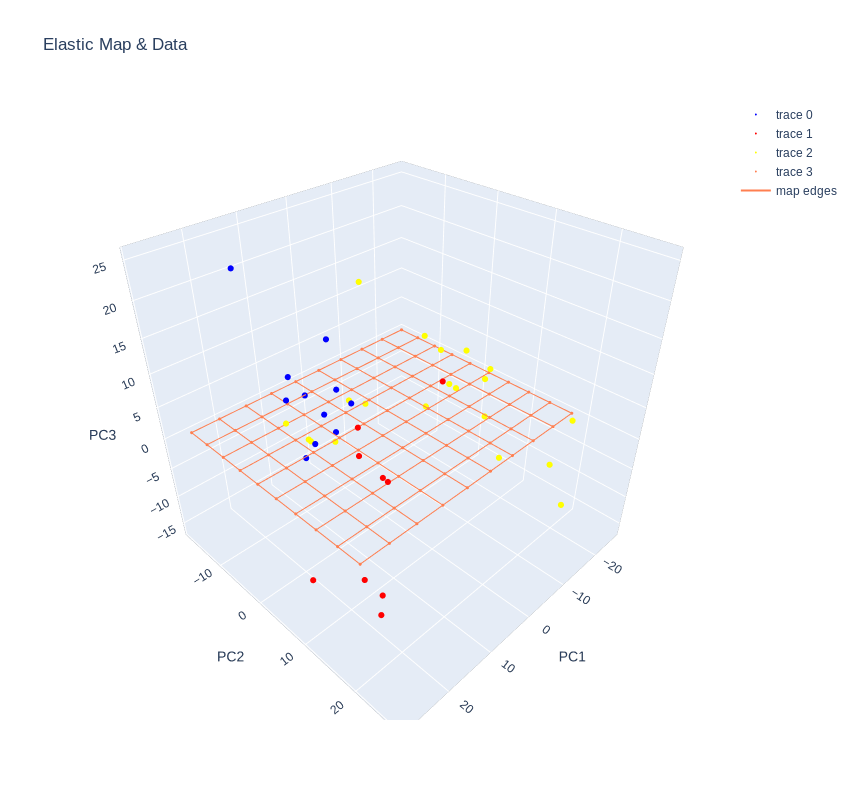

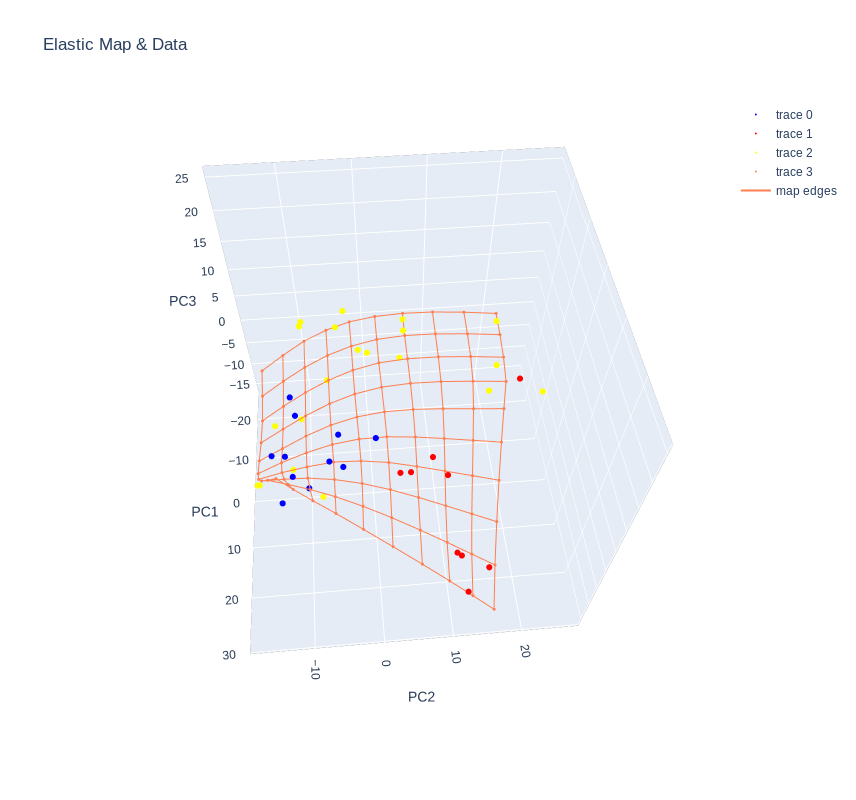

In [8]:
import scipy.io as sp
d2fn = sp.loadmat('/home/utilisateur/ElMap/tests/bladderCancer.mat')['d2fn'].T
col = sp.loadmat('/home/utilisateur/ElMap/tests/bladderCancer.mat')['col']
colours = ['blue', 'red', 'yellow']

_map = rect2DMap(10, 10)
_map.init(d2fn, 'pci')
drawMap(_map, d2fn, classes= col,markColour=colours,lineWidth= 0.5)

EM(_map, 
   d2fn, 
    constStretching = 0,
    constBending = .1, 
    func=L2,
    nInt=2, 
   delta = .75)
drawMap(_map, d2fn, classes= col,markColour=colours,lineWidth= 0.5)